This does not work. The SNS_analytic component fails when Emin and Emax are too close

In [1]:
workdir = '~/dv/sns-chops/resolution/CNCS/mcvine'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine


In [7]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components as mcomps
from mcni.utils import conversion as C

from matplotlib import pyplot as plt
%matplotlib notebook

# Explore

In [3]:
def fc_tof(Ei):
    from numpy import sqrt, pi
    L1=6.413  
    T0=(1.0+Ei);
    T0=198.2*pow(T0,-0.84098)/1.e6;
    return T0+(2286.3*L1)/sqrt(Ei)/1.e6;
fc_tof(100)

0.0014702921765780608

In [4]:
fc_z = 6.413
fc_len = 0.017
mon_z = fc_z + fc_len + 0.01 
emin, emax = 5, 5.005
eave = (emin+emax)/2
v = C.e2v(eave)
tof = mon_z/v

instrument = mcvine.instrument()

In [9]:
source_file = 'SNS_IRP2_TD_BL5_30o70p_fit_fit.dat'
moderator = mcomps.sources.SNS_source_analytic(
    name='moderator',
    xwidth=0.1, yheight=0.12, dist=1.000,
    focus_xw=0.06, focus_yh=0.14,
    Emin=emin, Emax=emax,
    p_power = 1.4,
    filename=source_file,
)
instrument.append(moderator, position=(0.0, 0.0, 0.0), orientation=(0.0, 0.0, 0.0))

fc = mcvine.components.optics.FermiChopper(
    Nslit=9, zero_time=0, height=0.102, width=0.053, length=fc_len, time=fc_tof(eave), nu=60.)
instrument.append(fc, position=(0,0,fc_z))

monitor = mcvine.components.monitors.TOF_monitor2(
    'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.9, tmax=tof*1.5)
instrument.append(monitor, position=(0,0,mon_z))

In [10]:
%%time
# quick sim
neutrons = instrument.simulate(int(1e3),outputdir="out", overwrite_datafiles=True, iteration_no=0)

CPU times: user 12.3 s, sys: 9.87 ms, total: 12.3 s
Wall time: 12.4 s


In [11]:
len(neutrons)

985

In [13]:
#ls 

In [14]:
ls out/step0/

Itof.h5  number_of_mc_samples


<IPython.core.display.Javascript object>


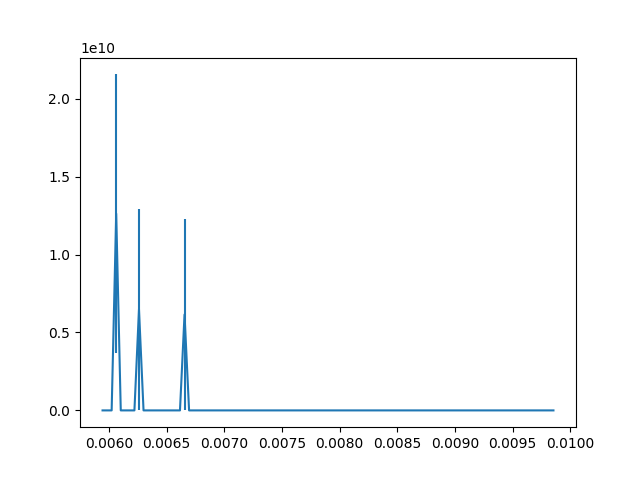

In [15]:
H.plot(hh.load('./out/step0/Itof.h5'))

# Loop

In [57]:
def calculatePulseShape(E, ncount=1e5):
    emin, emax = E*0.999, E*1.001
    eave = (emin+emax)/2
    v = C.e2v(eave)
    tof = mon_z/v

    instrument = mcvine.instrument()
    moderator = mcomps.sources.SNS_source_analytic(
        name='moderator',
        xwidth=0.1, yheight=0.12, dist=1.000,
        focus_xw=0.06, focus_yh=0.14,
        Emin=emin, Emax=emax,
        p_power = 1.4,
        filename=source_file,
    )
    instrument.append(moderator, position=(0.0, 0.0, 0.0), orientation=(0.0, 0.0, 0.0))

    fc = mcvine.components.optics.FermiChopper(
        Nslit=9, zero_time=0, height=0.102, width=0.053, length=fc_len, time=fc_tof(eave), nu=300.)
    instrument.append(fc, position=(0,0,fc_z))

    monitor = mcvine.components.monitors.TOF_monitor2(
        'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.2, tmax=tof*5,
        nchan=2000,
    )
    instrument.append(monitor, position=(0,0,mon_z))
    
    E_mon = mcvine.components.monitors.E_monitor(
        name='E_mon', Emin=E*.95, Emax=E*1.05, nchan=200, filename='E_mon.dat', xwidth=0.1, yheight=0.1
    )
    instrument.append(E_mon, position=(0,0,mon_z))
    #
    instrument.simulate(int(ncount),outputdir="out", overwrite_datafiles=True, iteration_no=0)
    return hh.load('./out/step0/Itof.h5')

In [58]:
%%time
h = calculatePulseShape(.1)

CPU times: user 6.42 s, sys: 84.1 ms, total: 6.5 s
Wall time: 6.56 s


In [23]:
%matplotlib notebook

<IPython.core.display.Javascript object>


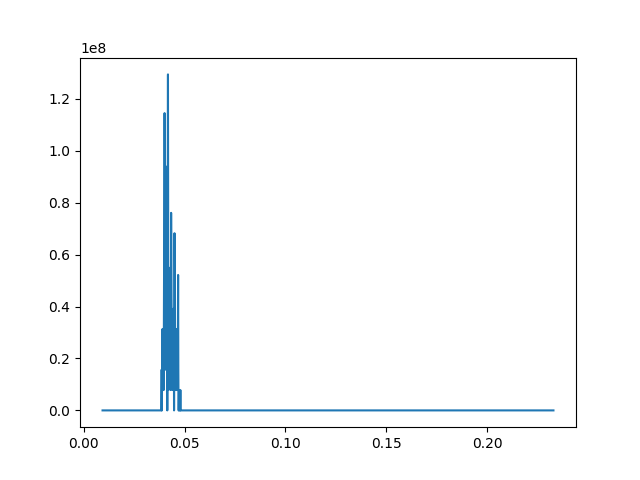

In [59]:
plt.figure()
plt.plot(h.tof, h.I)

<IPython.core.display.Javascript object>


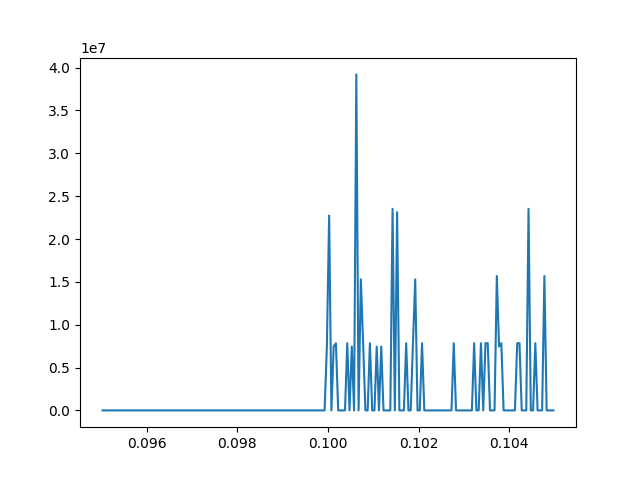

In [61]:
plt.figure()
h = hh.load('./out/step0/E_mon.h5')
plt.plot(h.energy, h.I)

In [25]:
Es = np.logspace(-1, 2)

In [45]:
import tqdm

In [51]:
spectra = []
for E in tqdm.tqdm(Es):
    spectra.append(calculatePulseShape(E, ncount=5e6))

100%|██████████| 50/50 [29:46<00:00, 36.53s/it]


In [34]:
len(Es)

50

In [38]:
from mcni.utils import conversion as conv

<IPython.core.display.Javascript object>


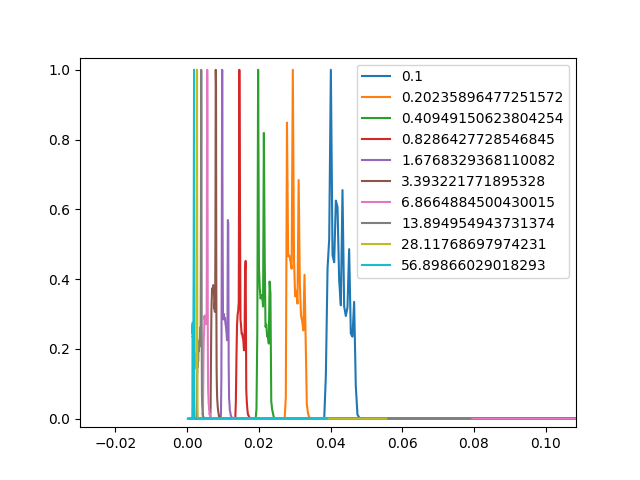

In [47]:
plt.figure()
for E, sp in zip(Es, spectra)[::5]:
    plt.plot(sp.tof, sp.I/sp.I.max(), label=E)
plt.legend()

<IPython.core.display.Javascript object>


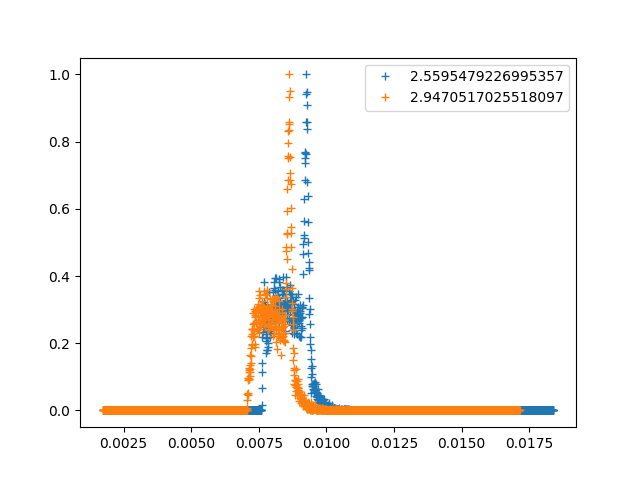

In [52]:
plt.figure()
for E, sp in zip(Es, spectra):
    if E<2.5 or E>3.2: continue
    plt.plot(sp.tof, sp.I/sp.I.max(), '+', label=E)
plt.legend()

In [23]:
fwhms = []
for E, sp in zip(Es, spectra):
    I = sp.I[:-5]; tof = sp.tof[:-5]
    max = I.max()
    hm = max/2
    top = tof[I>hm]
    fwhms.append(top[-1]-top[0])

In [24]:
fwhms = np.array(fwhms)

In [25]:
np.savetxt('beam-fc-fwhms.txt', np.array([Es, fwhms]).T)

In [26]:
beam_fwhms = np.loadtxt('beam-fwhms.txt')[:, 1]

<IPython.core.display.Javascript object>


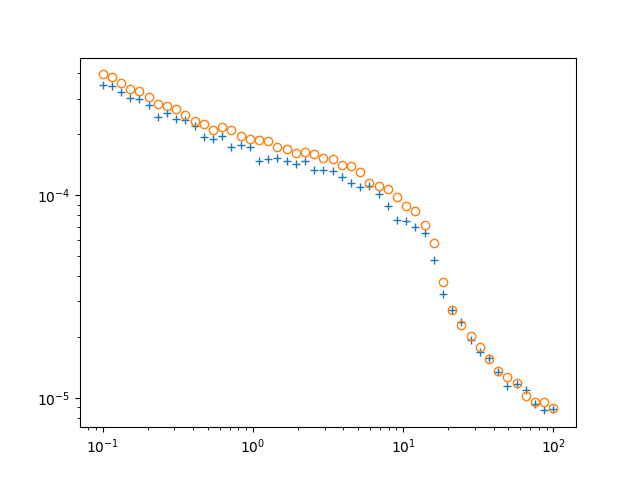

In [29]:
plt.figure()
plt.loglog(Es, fwhms, '+')
plt.loglog(Es, beam_fwhms, 'o', mfc='none')

<IPython.core.display.Javascript object>


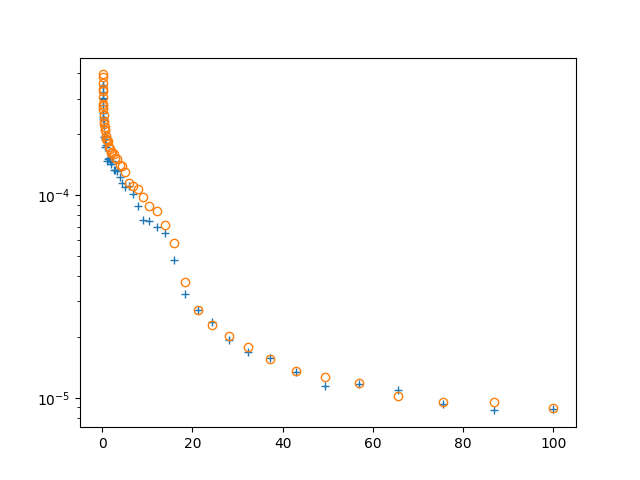

In [30]:
plt.figure()
plt.semilogy(Es, fwhms, '+')
plt.semilogy(Es, beam_fwhms, 'o', mfc='none')